In [1]:
import numpy as np
import moose
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
EREST_ACT = -70e-3 # Resting membrane potential
ENa = 115e-3 + EREST_ACT # Sodium reversal potential
EK = -12e-3 + EREST_ACT # Potassium reversal potential
DIA = 30e-6 # Diameter of the cell/compartment

In [3]:
model=moose.Neutral('/model')
data=moose.Neutral('/data')

In [4]:
# Now, we will create a function that creates a compartment under library only if it does not exist
# already
def get_hh_proto():
    lib=moose.Neutral('/library')
    comp_path=f'{lib.path}/comp'
    if moose.exists(comp_path):
        return moose.element(comp_path)

    # Making a prototype compartment
    proto_comp=moose.Compartment(comp_path)
    sarea=np.pi * DIA * DIA
    Cm_spec= 1e-2 # (1 uF/cm^2)  specific capacitance in SI units
    Gm_spec= 3 # (0.3 mS/cm^2)   specific conductance in SI units
    proto_comp.Cm=1e-2 * sarea # setting the membrane capacitance
    proto_comp.Rm=1/(3 * sarea) # setting the membrane resistance
    proto_comp.Ra=1/(3 * sarea) # setting the axial resistance
    proto_comp.initVm=-70e-3 # setting initial membrane potential
    proto_comp.Em=-59.89e-3 # setting the reversal potential for the leak channels

    # Now, we will set up the HHChannels
    nachan=moose.HHChannel(f'{proto_comp.path}/Na')
    kchan=moose.HHChannel(f'{proto_comp.path}/K')
    moose.connect(nachan,'channel',proto_comp,'channel')
    moose.connect(kchan,'channel',proto_comp,'channel')

    nachan.Ek= ENa
    nachan.Gbar= 120 * 10 * sarea # 120 mS/cm^2 in HHM exp. In SI, we multiply by 10
    nachan.Xpower=3 # for m gating particle
    nachan.Ypower=1 # for h gating particle

    kchan.Ek= EK
    kchan.Gbar= 36 * 10 * sarea # 36 mS/cm^2 in HHM exp
    kchan.Xpower=4 # for n gating particle

    # setting up gates
    m_gate=moose.HHGate(f'{nachan.path}/gateX')
    h_gate=moose.HHGate(f'{nachan.path}/gateY')

    n_gate=moose.HHGate(f'{kchan.path}/gateX')

    
    vmin=-110e-3
    vmax=50e-3
    vdivs=1000
    v=np.linspace(vmin,vmax,vdivs)

    

    #Expressions for alpha and beta for gates m,h,n

    m_gate_alphaExpr = 1e3 * 0.1 * (25 - 1e3 * (v - (EREST_ACT)))/(np.exp((25 - 1e3 * (v - (EREST_ACT)))/10) - 1)
    m_gate_betaExpr =  1e3 * 4 * np.exp(- 1e3 * (v - (EREST_ACT))/ 18)
    h_gate_alphaExpr = 1e3 * 0.07 * np.exp(- 1e3 * (v - (EREST_ACT))/ 20)
    h_gate_betaExpr = 1e3 / (np.exp((30 - 1e3 * (v - (EREST_ACT))) / 10) + 1)
    n_gate_alphaExpr = 1e3 * 0.01 * (10 - 1e3 * (v - (EREST_ACT))) / (np.exp((10 - 1e3 * (v - (EREST_ACT)))/10) - 1)
    n_gate_betaExpr = 1e3 * 0.125 * np.exp(-1e3 * (v - (EREST_ACT)) / 80)

    # Now, using interpolation we will calculate the values of alpha and beta at different voltages
    # in a given range
    n_gate.tableA=n_gate_alphaExpr
    n_gate.tableB=n_gate_alphaExpr + n_gate_betaExpr
    m_gate.tableA=m_gate_alphaExpr
    m_gate.tableB=m_gate_alphaExpr + m_gate_betaExpr
    h_gate.tableA=h_gate_alphaExpr 
    h_gate.tableB=h_gate_alphaExpr + h_gate_betaExpr

    n_gate.min,n_gate.max,n_gate.divs=vmin,vmax,vdivs
    m_gate.min,m_gate.max,m_gate.divs=vmin,vmax,vdivs
    h_gate.min,h_gate.max,h_gate.divs=vmin,vmax,vdivs
    
    n_gate.useInterpolation=True
    m_gate.useInterpolation=True
    h_gate.useInterpolation=True
    

    return proto_comp    

In [5]:
proto=get_hh_proto()

In [6]:
comps1=[]
tabs1=[]
for ii in range(0,10):
    moose.copy(proto,model,f'nrn_{ii}')
    comps1.append(moose.element(f'{model.path}/nrn_{ii}'))
    if len(comps1) > 1:
        moose.connect(comps1[-2], 'raxial', comps1[-1], 'axial')

    vm_tab=moose.Table(f'{data.path}/vm_{ii}')
    moose.connect(vm_tab,'requestOut',comps1[ii],'getVm')
    tabs1.append(vm_tab)

comps2=[]
tabs2=[]
for jj in range(10,20):
    moose.copy(proto,model,f'nrn_{jj}')
    comps2.append(moose.element(f'{model.path}/nrn_{jj}'))
    if len(comps2) > 1:
        moose.connect(comps2[-2], 'raxial', comps2[-1], 'axial')

    vm_tab=moose.Table(f'{data.path}/vm_{jj}')
    moose.connect(vm_tab,'requestOut',comps2[jj-10],'getVm')
    tabs2.append(vm_tab)

comps3=[]
tabs3=[]
for ii in range(20,30):
    moose.copy(proto,model,f'nrn_{ii}')
    comps3.append(moose.element(f'{model.path}/nrn_{ii}'))
    if len(comps3) > 1:
        moose.connect(comps3[-2], 'raxial', comps3[-1], 'axial')

    vm_tab=moose.Table(f'{data.path}/vm_{ii}')
    moose.connect(vm_tab,'requestOut',comps3[ii-20],'getVm')
    tabs3.append(vm_tab)
    

In [7]:
moose.connect(comps1[-1],'raxial',comps2[0],'axial')
moose.connect(comps1[-1],'raxial',comps3[0],'axial')

<moose.SingleMsg id=5 dataIndex=180 path=/Msgs[0]/singleMsg[180]>

In [8]:
# Main branch: comps1
# Branch 1 and 2 comps2 and comps3 (either one)

In [9]:
cclamp=moose.PulseGen(f'{model.path}/input')
moose.connect(cclamp,'output',comps2[9],'injectMsg')
moose.connect(cclamp,'output',comps3[9],'injectMsg')

<moose.SingleMsg id=5 dataIndex=182 path=/Msgs[0]/singleMsg[182]>

In [10]:
cclamp.firstDelay=50e-3
cclamp.firstWidth=200e-3
cclamp.firstLevel=1e-9

In [11]:
# Now, we will attempt to plot the voltage at different parts of the Y shaped branch at the same time. 
# For this, we can specify a moment in time and extract the value of the potentials at that index and plot against the
# compartment numbers

In [12]:
def Vm_vs_x_const_t(time_ind):

    t=np.arange(len(tabs1[0].vector))*tabs1[0].dt*1e3
    main=[]
    b2=[]
    b3=[]
    for i in range(0,10):
        main.append(tabs1[i].vector[int(t[time_ind*10])*10]*1e3)
    
    df_main=pd.DataFrame({
        'Value':main
    })
    
    for i in range(0,10):
        b2.append(tabs2[i].vector[int(t[time_ind*10])*10]*1e3)
    
    df_b2=pd.DataFrame({
        'Value':b2
    })
    
    for i in range(0,10):
        b3.append(tabs3[i].vector[int(t[time_ind*10])*10]*1e3)
    
    df_b3=pd.DataFrame({
        'Value':b3
    })

    fig,axes=plt.subplots(3,1,sharex='all',figsize=(7,10))
    
    for i in range(10):
        sns.scatterplot(data=df_main,ax=axes[0],legend=False)
        
    for i in range(10):
        sns.scatterplot(data=df_b2,ax=axes[1],legend=False)
    
    for i in range(10):
        sns.scatterplot(data=df_b3,ax=axes[2],legend=False)

    axes[0].set_title('Main Branch')
    axes[1].set_title('Branch 1')
    axes[2].set_title('Branch 2')
    
    plt.xlabel('Compartment Index')
    plt.xticks(range(0,10,1))
    axes[1].set_ylabel('Membrane Potential (mv)')

    return fig

    
def show_plot():

    t=np.arange(len(tabs1[0].vector))*tabs1[0].dt*1e3
    fig,axes=plt.subplots(3,1,sharex='all',figsize=(12,10))
    for i in tabs1:
        axes[0].plot(t,i.vector*1e3)
        axes[0].set_ylabel('Vm (mv)')
        axes[0].set_title('Main Branch')
        
    for i in tabs2:
        axes[1].plot(t,i.vector*1e3)
        axes[1].set_ylabel('Vm (mv)')
        axes[1].set_title('Branch_1')
    
    j=0
    for i in tabs3:
        axes[2].plot(t,i.vector*1e3,label=f'Vm_{j}')
        axes[2].set_ylabel('Vm (mv)')
        axes[2].set_title('Branch_2')
        axes[2].set_xlabel('TIme')
        j+=1
    
    plt.legend()

    return fig

In [13]:
def run_sim():
    runtime=200e-3
    moose.reinit()
    moose.start(runtime)
    time_ind=150

    return time_ind

time_ind = run_sim()  # ✅ Store the returned value


SystemExit: 0

/home/pramesh/anaconda3/envs/moose/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


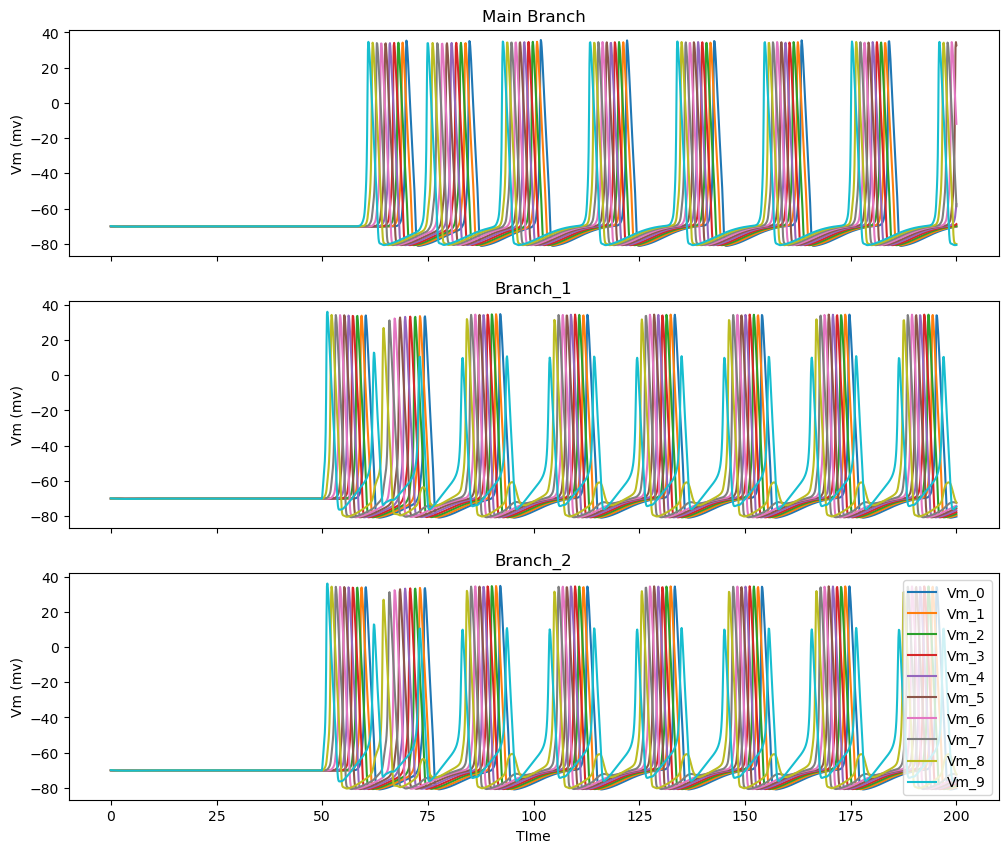

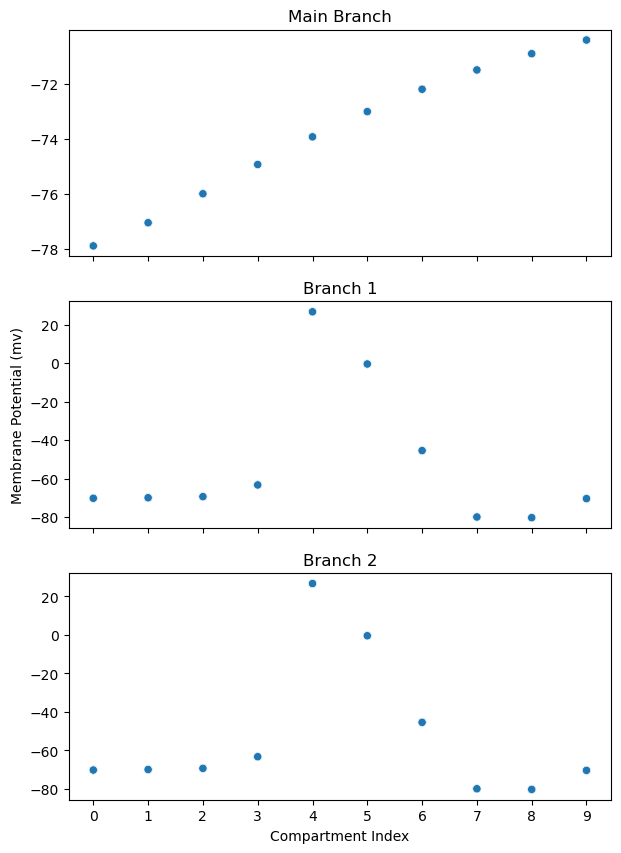

In [14]:
import sys
from PyQt5.QtWidgets import (
    QApplication, QWidget, QVBoxLayout, QPushButton, QHBoxLayout
)
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

# --- Simulation and Plotting Functions (from your notebook) ---
import numpy as np
import matplotlib.pyplot as plt


# --- PyQt5 GUI ---
class MainWindow(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("MOOSE Simulation Viewer")
        self.setGeometry(100, 100, 1600, 1000)
        
        self.layout = QVBoxLayout()
        self.setLayout(self.layout)

        # Buttons
        button_layout = QHBoxLayout()
        self.button1 = QPushButton("Run + Show Plot")
        self.button2 = QPushButton("Run + Vm vs X Const t")
        self.button1.clicked.connect(self.handle_button1)
        self.button2.clicked.connect(self.handle_button2)
        button_layout.addWidget(self.button1)
        button_layout.addWidget(self.button2)
        self.layout.addLayout(button_layout)

        # Matplotlib canvas
        self.canvas = FigureCanvas(Figure(figsize=(5, 6)))
        self.layout.addWidget(self.canvas)

    def handle_button1(self):
        run_sim()
        self.plot_on_canvas(show_plot())

    def handle_button2(self):
        time_ind=run_sim()
        self.plot_on_canvas(Vm_vs_x_const_t(time_ind))

    def plot_on_canvas(self, fig):
    # Clear previous axes
        self.canvas.figure.clf()
        
        # Copy subplots from fig
        for i, ax in enumerate(fig.axes):
            new_ax = self.canvas.figure.add_subplot(3, 1, i + 1)
            
            # Copy scatter collections
            for col in ax.collections:
                offsets = col.get_offsets()
                if len(offsets) > 0:
                    x = offsets[:, 0]
                    y = offsets[:, 1]
                    new_ax.scatter(x, y, c=col.get_facecolors(), s=col.get_sizes())
            
            # Also support normal plot lines, just in case
            for line in ax.get_lines():
                new_ax.plot(line.get_xdata(), line.get_ydata())
    
            # Copy title and labels
            new_ax.set_title(ax.get_title())
            new_ax.set_xlabel(ax.get_xlabel())
            new_ax.set_ylabel(ax.get_ylabel())
        
        self.canvas.draw()

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = MainWindow()
    window.show()
    sys.exit(app.exec_())
